## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

## Data

In [2]:
df = pd.read_csv('icl_train.zip', 
                 compression='zip',
                 sep=',',
                 parse_dates=['date'])
df.head()

,date,zone,Вызов специальной бригады,Перевозка плановая,Перевозка экстренная,авария ( сбило машиной) постр.,аллергия( задыхается),аллергия( отекло лицо),аллергия( сыпь),аритмия,...,травма позвоночника,травма ребер( задыхается),травма ребер( не задыхается),травма руки,травма руки( кровотечение),тяж.ст.опьянения,укусила собака,умер?,умер?( хронический больной),умирает
0,2019-01-01 07:00:00,П/станция 1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-01 08:00:00,П/станция 1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,2019-01-01 09:00:00,П/станция 1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2019-01-01 10:00:00,П/станция 1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-01 11:00:00,П/станция 1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.shape

(157831, 155)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157831 entries, 0 to 157830
Columns: 155 entries, date to умирает
dtypes: datetime64[ns](1), int64(153), object(1)
memory usage: 186.6+ MB


In [5]:
df.count() / df.shape[0] # пропусков нет

date                           1.0
zone                           1.0
Вызов специальной бригады      1.0
Перевозка плановая             1.0
Перевозка экстренная           1.0
                              ... 
тяж.ст.опьянения               1.0
укусила собака                 1.0
умер?                          1.0
умер?( хронический больной)    1.0
умирает                        1.0
Length: 155, dtype: float64

In [64]:
TARGET = 'total'
df[TARGET] = df.iloc[:, 2:].sum(axis=1)

In [66]:
df.zone.nunique() # 9 подстанций

9

#### Погода

In [413]:
weather_df = pd.read_csv('weather.csv', encoding='utf-8')

In [414]:
weather_df.head()

,dr,time,weather,temp,w_spid,p
0,30декабрь2021,00:00,ясно,-12°,1 м/с,767
1,30декабрь2021,03:00,ясно,-15°,"<td><span class=""p"">766</span><span>мм рт.ст.<...",766
2,30декабрь2021,06:00,ясно,-16°,"<td><span class=""p"">765</span><span>мм рт.ст.<...",765
3,30декабрь2021,09:00,пасмурно,-16°,1 м/с,763
4,30декабрь2021,12:00,пасмурно,-13°,1 м/с,761


In [415]:
months = {
    'январь': '01',
    'февраль': '02',
    'март': '03',
    'апрель': '04',
    'май': '05',
    'июнь': '06',
    'июль': '07',
    'август': '08',
    'сентябрь':'09',
    'октябрь': '10',
    'ноябрь': '11',
    'декабря': '12',
    'декабрь': '12'
}

In [416]:
weather_df.dr = weather_df.dr.replace(months, regex=True)

In [417]:
import re
weather_df.temp = weather_df.temp.apply(lambda x: re.sub('°', '', x))

In [418]:
weather_df.w_spid = weather_df.w_spid.apply(lambda x: re.sub(r'<[\w\W]*>', '', x))
weather_df.w_spid = weather_df.w_spid.apply(lambda x: re.sub(' м/с', '', x))
weather_df.w_spid = weather_df.w_spid.replace('', np.nan)

In [419]:
weather_df.dr = weather_df.dr.apply(lambda x: x if len(x) == 8 else '0'+x)
weather_df.dr = weather_df.dr.apply(lambda x: ''.join(x.split()))
weather_df.time = weather_df.time.replace('24:00', '00:00')
weather_df['dt'] = pd.to_datetime(weather_df.dr+' '+weather_df.time, format='%d%m%Y %H:%M')

In [420]:
weather_df.drop(['dr', 'time'], axis=1, inplace=True)

In [421]:
weather_df[['temp', 'w_spid', 'p']] = weather_df[['temp', 'w_spid', 'p']].astype(float)

In [422]:
from sklearn.impute import KNNImputer

def knn_impute(df, col):
    imputer = KNNImputer(n_neighbors=3)
    imp_col = imputer.fit_transform(df[col].to_numpy().reshape(-1, 1))
    return imp_col

In [423]:
weather_df.w_spid = knn_impute(weather_df, 'w_spid')

In [424]:
weather_df = weather_df.sort_values('dt').set_index('dt')

In [425]:
weather_df.head()

,weather,temp,w_spid,p
dt,,,,
2019-01-01 00:00:00,пасмурно,-8.0,2.0,765.0
2019-01-01 00:00:00,пасмурно,-13.0,2.0,761.0
2019-01-01 03:00:00,пасмурно,-8.0,3.0,765.0
2019-01-01 06:00:00,пасмурно,-9.0,2.0,765.0
2019-01-01 09:00:00,малооблачно,-10.0,2.0,765.0


In [426]:
weather_df.tail()

,weather,temp,w_spid,p
dt,,,,
2021-12-30 09:00:00,пасмурно,-16.0,1.0,763.0
2021-12-30 12:00:00,пасмурно,-13.0,1.0,761.0
2021-12-30 15:00:00,пасмурно,-11.0,2.0,758.0
2021-12-30 18:00:00,пасмурно,-8.0,2.0,754.0
2021-12-30 21:00:00,пасмурно,-5.0,5.0,750.0


In [427]:
weather_df.drop(weather_df[weather_df.index.duplicated()].index, axis=0, inplace=True)

In [428]:
# weather_df.to_csv('prepared_weather_data.csv', encoding='cp1251', index=False)

In [429]:
def linear_interp(df, col):
    min_date = df.index.min() # index is datetime
    max_date = df.index.max()
    date_range = pd.date_range(min_date, max_date, freq='1H')
    new_time_series = pd.Series(np.nan, index=date_range)
    new_time_series.loc[df.index] = df[col]
    if type(df[col].iloc[0]) == str:
        return new_time_series.interpolate('pad')
    else:
        return new_time_series.interpolate('linear')

In [433]:
weather_interpolated = dict()
for col in weather_df.columns:
    weather_interpolated[col] = linear_interp(weather_df, col)

In [434]:
pd.DataFrame(weather_interpolated)

,weather,temp,w_spid,p
2019-01-01 03:00:00,пасмурно,-8.000000,3.000000,765.000000
2019-01-01 04:00:00,пасмурно,-8.333333,2.666667,765.000000
2019-01-01 05:00:00,пасмурно,-8.666667,2.333333,765.000000
2019-01-01 06:00:00,пасмурно,-9.000000,2.000000,765.000000
2019-01-01 07:00:00,пасмурно,-9.333333,2.000000,765.000000
...,...,...,...,...
2021-12-30 17:00:00,пасмурно,-9.000000,2.000000,755.333333
2021-12-30 18:00:00,пасмурно,-8.000000,2.000000,754.000000
2021-12-30 19:00:00,пасмурно,-7.000000,3.000000,752.666667
2021-12-30 20:00:00,пасмурно,-6.000000,4.000000,751.333333


In [435]:
# pd.DataFrame(weather_interpolated).to_csv('weather_prepared_interpolated.csv', encoding='cp1251')

## EDA

In [6]:
for col in df.iloc[:, 5:].columns:
    print(col)

авария ( сбило машиной) постр.
аллергия( задыхается)
аллергия( отекло лицо)
аллергия( сыпь)
аритмия
без сознания
без сознания( сахарный диабет)
без сознания( травма головы)
белая горячка
боли в груди
боли в груди( продуло)
боли в груди( травма грудной клетки)
боли в животе
боли в животе( беременность)
боли в животе( выс. температура)
боли в животе( жидкий стул)
боли в животе( приступ печени)
боли в животе( приступ почек)
боли в животе( рвота)
болит глаз( травмы нет)
болит голова( травмы нет)
болит нога( травмы нет)
болит рука( травмы нет)
болит спина( травмы нет)
болит ухо
бронхиальная астма( задых.)
бронхиальная астма( хрон)
весь в крови
взрывное устройство
выпадение трубки
выс. давление
выс. давление( боли в сердце)
выс. давление( выс. температура)
выс. давление( голов.боль,головокруж)
выс. давление( не помогают лекарства)
выс. давление( немеет язык)
выс. давление( отнялась рука,нога)
выс. давление( перекосило лицо)
выс. давление( рвота)
выс. давление( хрон)
выс. темп.
выс. темп.( за

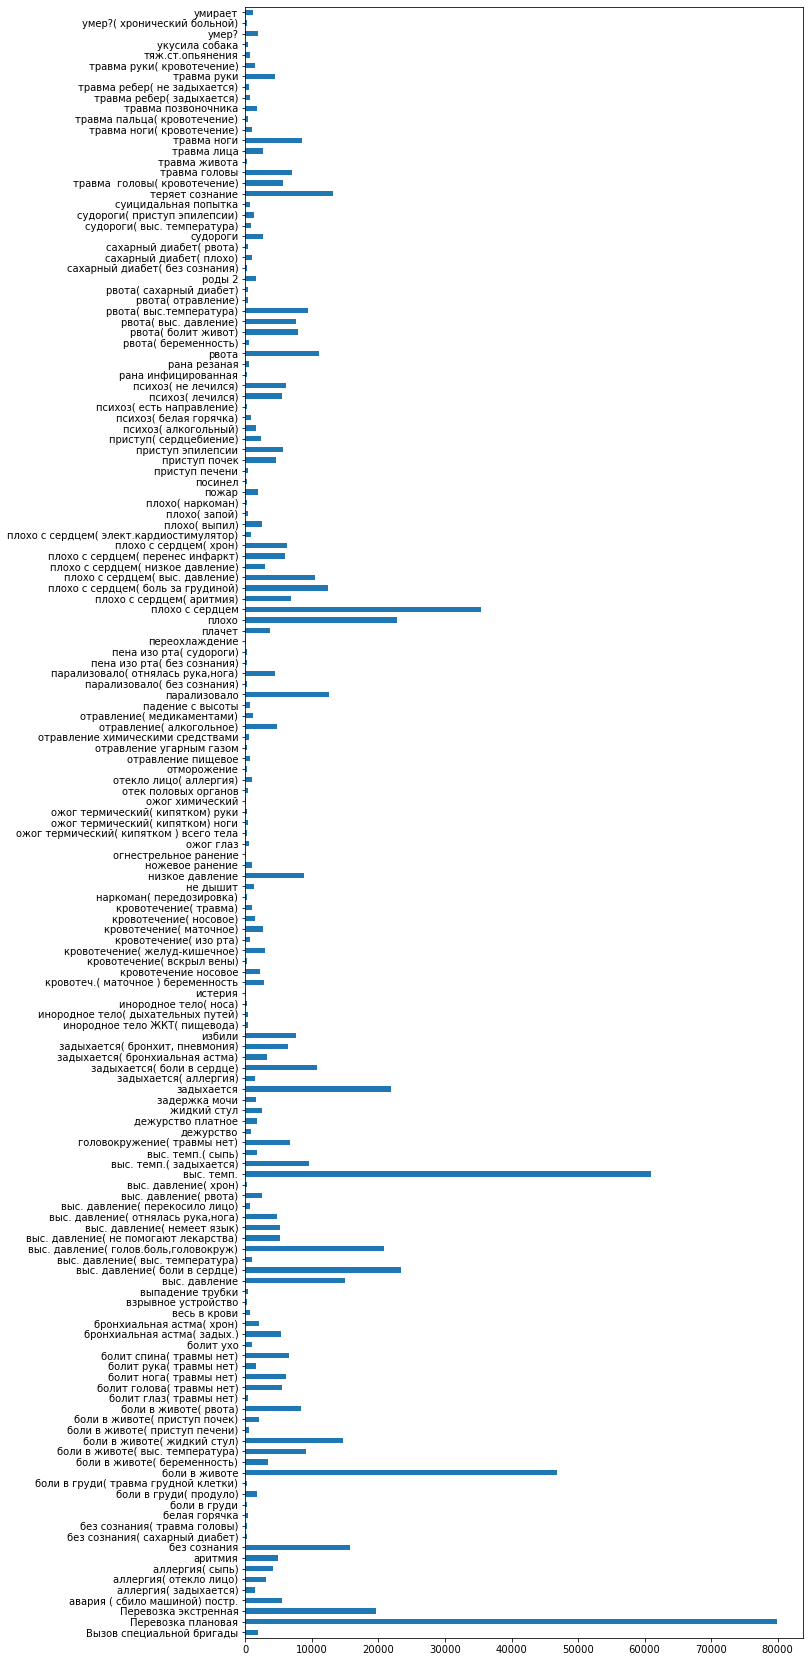

In [62]:
df.iloc[:, 2:].sum().plot(kind='barh', figsize=(10,30));

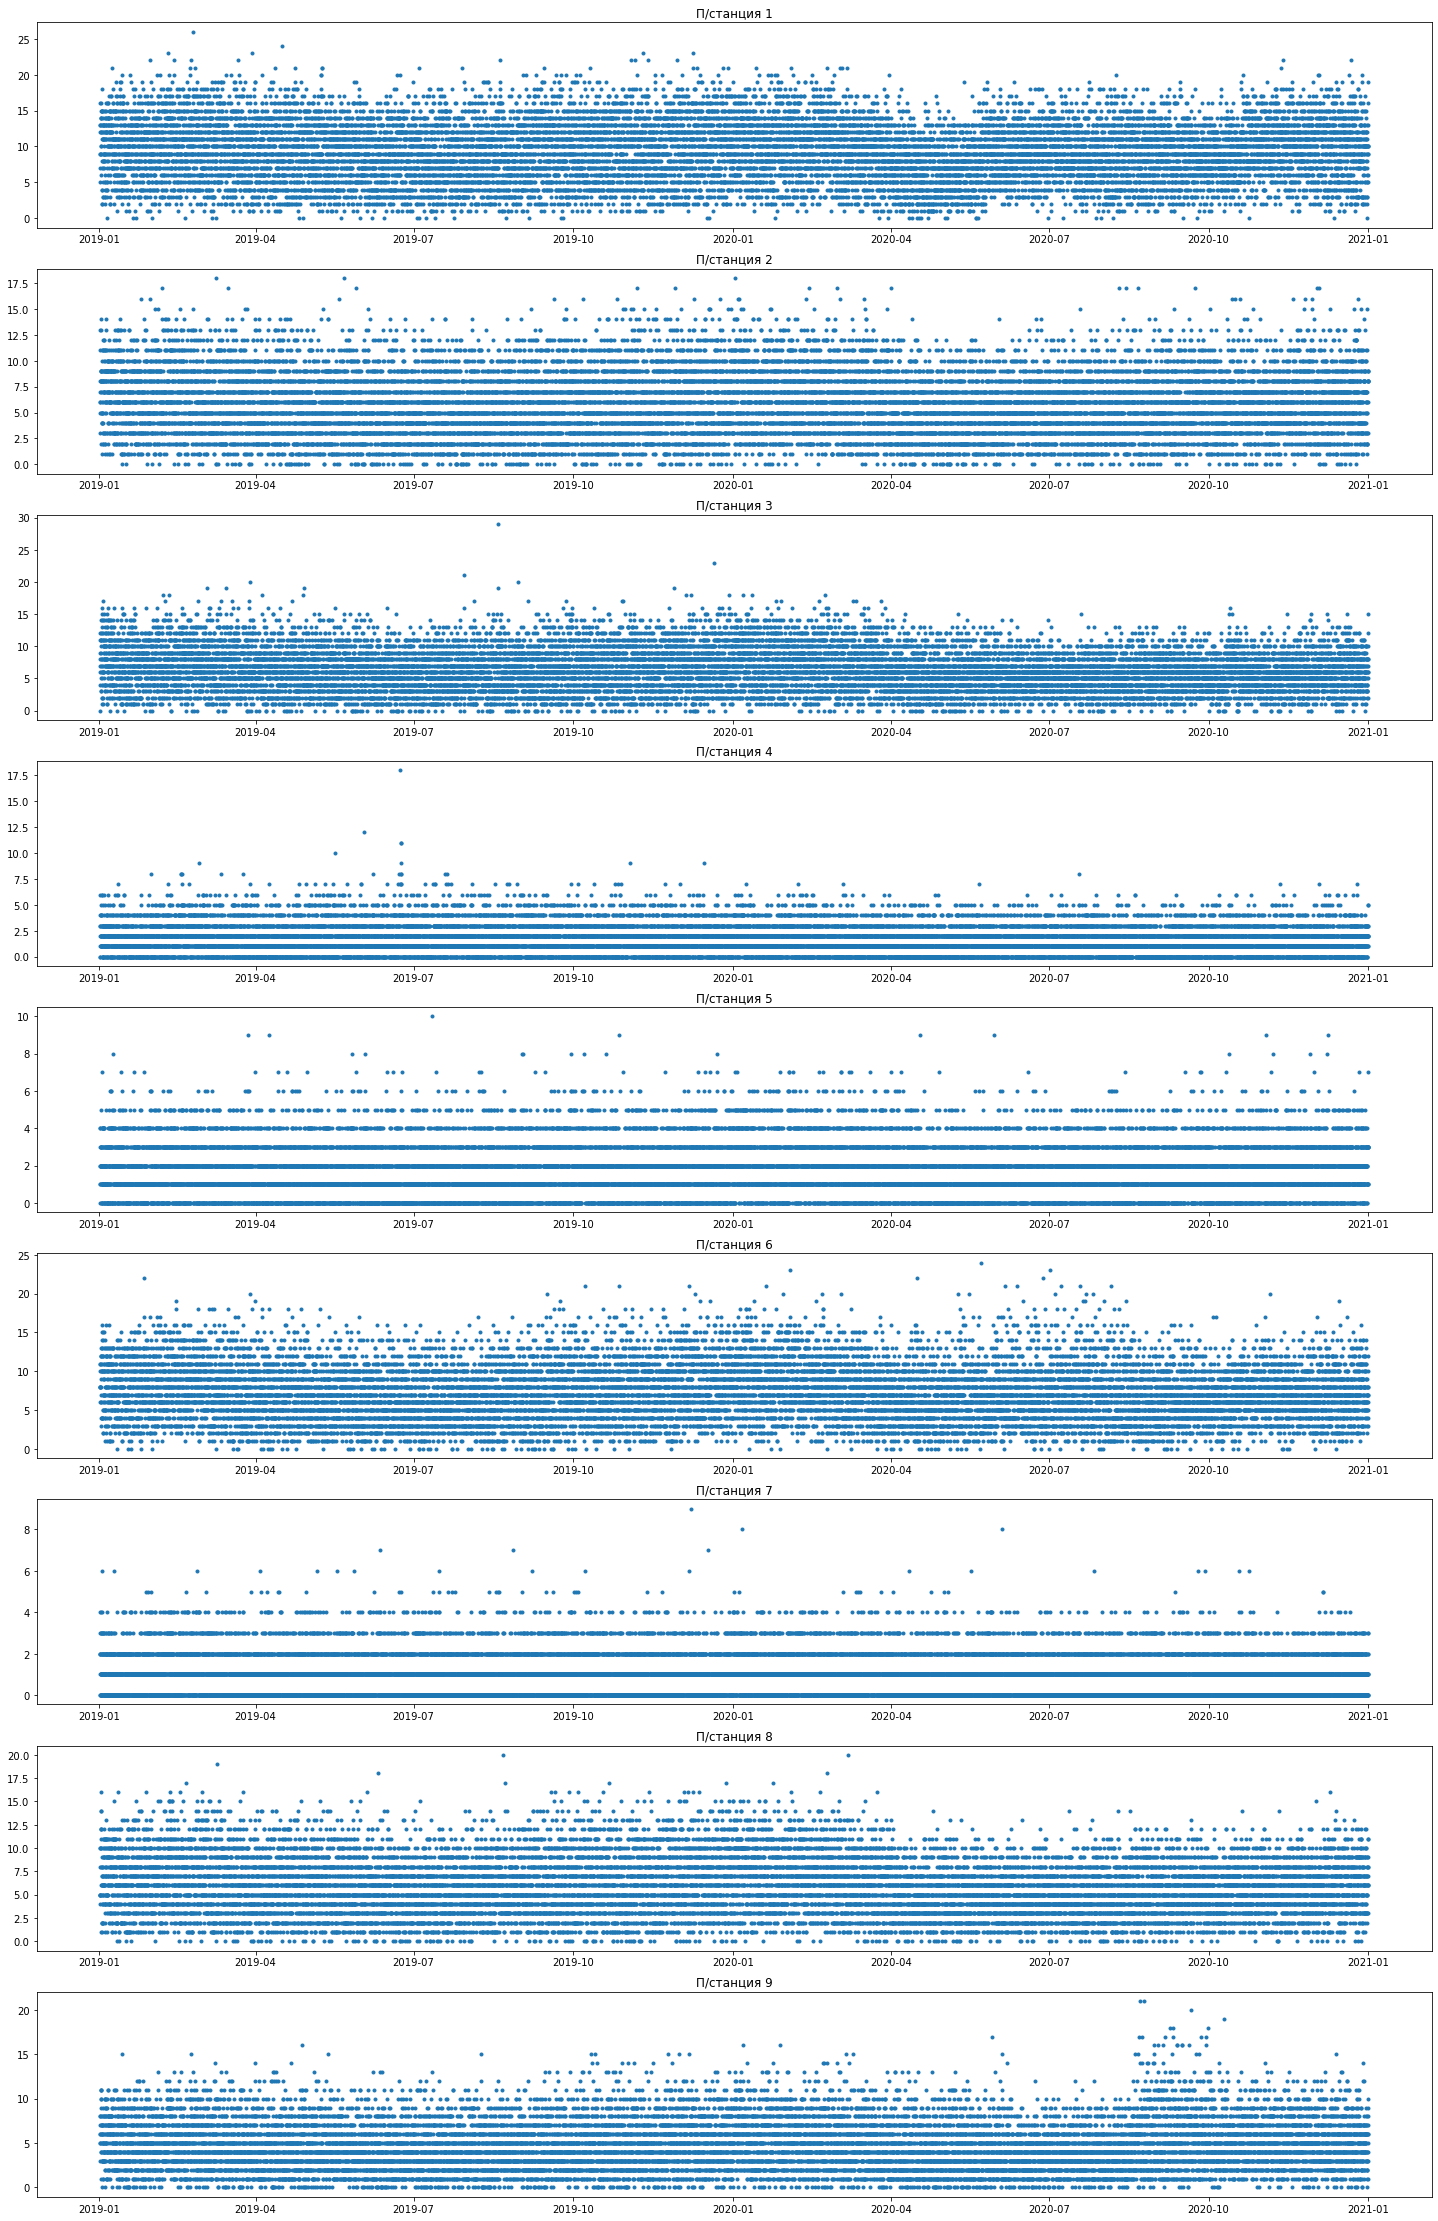

In [75]:
stations = df.zone.unique()
fig, axs = plt.subplots(len(stations), 1, figsize=(25,40))
for i,st in enumerate(stations):
    st_df = df[df.zone == st][['date', 'total']]
    axs[i].plot(st_df.date, st_df.total, '.')
    axs[i].set_title(st)
plt.show();

Различия в нагрузках точно есть. Выбросы тоже просматриваются.

In [80]:
def plot_timeseries(df, station, start_date, end_date):
    fig, ax = plt.subplots(figsize=(20,8))
    st_df = df[df.zone == station][['date', 'total']]
    st_df = st_df.loc[(st_df.date >= pd.to_datetime(start_date)) & (st_df.date <= pd.to_datetime(end_date))]
    ax.plot(st_df.date, st_df.total, '.--')
    ax.set_title(station)
    plt.show();

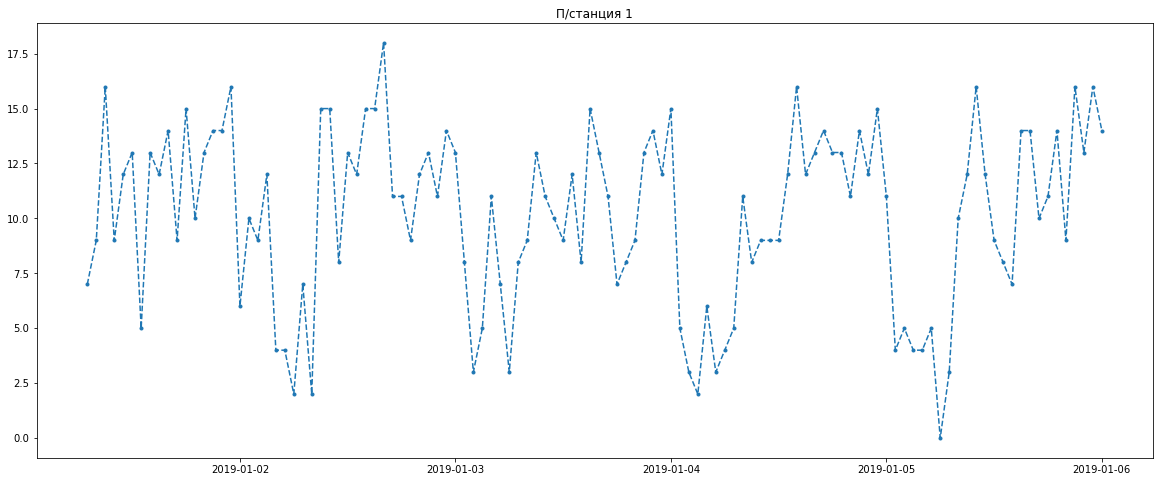

In [83]:
plot_timeseries(df, stations[0], '20190101', '20190106')

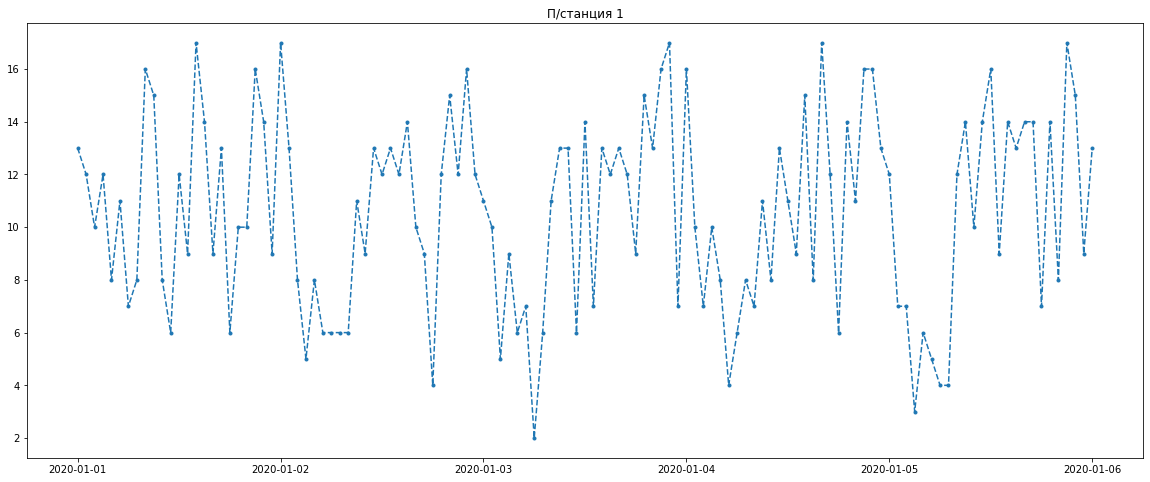

In [87]:
plot_timeseries(df, stations[0], '20200101', '20200106')

Видно снижение нагрузки под утро.

In [86]:
for st in stations:
    st_df = df[df.zone == st]
    case_cnt = st_df.iloc[:, 2:].sum(axis=0)
    print(st, case_cnt[case_cnt == 0].index)

П/станция 1 Index([], dtype='object')
П/станция 2 Index([], dtype='object')
П/станция 3 Index([], dtype='object')
П/станция 4 Index([], dtype='object')
П/станция 5 Index([], dtype='object')
П/станция 6 Index([], dtype='object')
П/станция 7 Index(['ожог химический', 'переохлаждение'], dtype='object')
П/станция 8 Index([], dtype='object')
П/станция 9 Index([], dtype='object')


Навряд ли подстанции на чём-то специализируются.

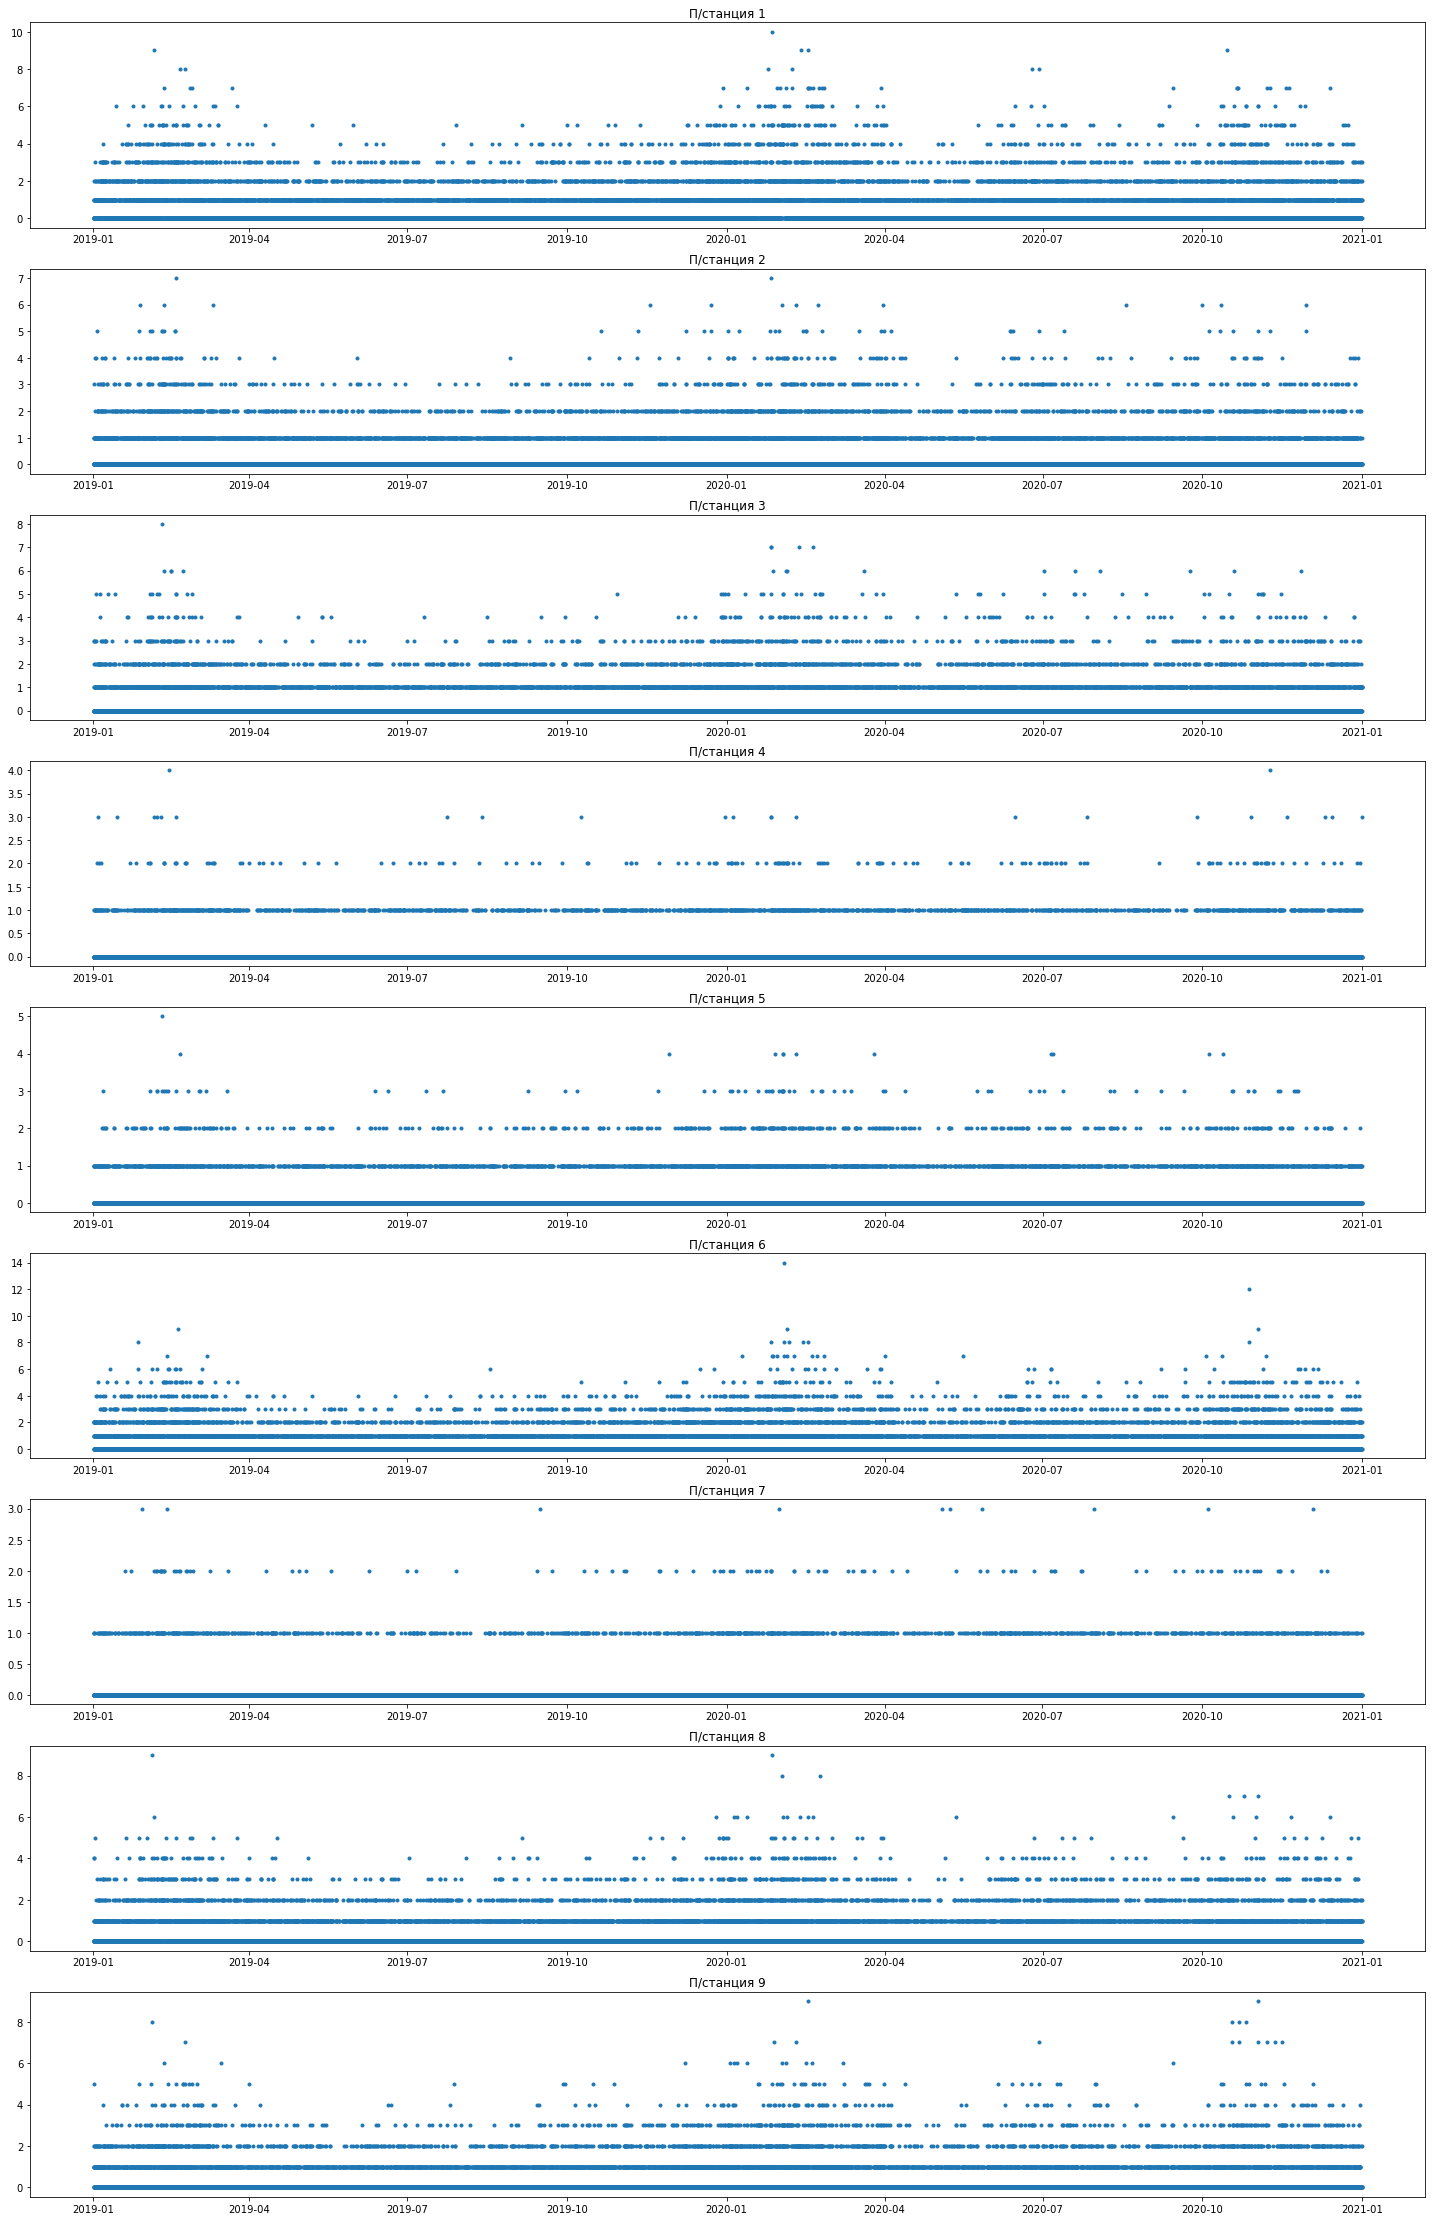

In [92]:
stations = df.zone.unique()
fig, axs = plt.subplots(len(stations), 1, figsize=(25,40))
for i,st in enumerate(stations):
    st_df = df[df.zone == st][['date', 'выс. темп.']]
    axs[i].plot(st_df.date, st_df['выс. темп.'], '.')
    axs[i].set_title(st)
plt.show();

Возможно, вызовы по поводу температуры будут коррелировать с ковидной статистикой.

__________________________________________

In [96]:
var = df.total
half1, half2 = var.iloc[:len(var)//2], var.iloc[len(var)//2:]

mean1, mean2 = half1.mean(), half2.mean()
var1, var2, = half1.var(), half2.var()
 
print("Means: %5f, %5f" %(mean1,mean2))
print("Variances: %5f, %5f" %(var1,var2))

Means: 5.337262, 4.372168
Variances: 16.372060, 12.136063


In [97]:
part1, part2, part3 = var[:len(var)//3], var[len(var)//3:2*len(var)//3], var[2*len(var)//3:]

mean1, mean2, mean3 = part1.mean(), part2.mean(), part3.mean()
var1, var2, var3 = part1.var(), part2.var(), part3.var()
 
print("Means: %5f, %5f, %5f" %(mean1,mean2,mean3))
print("Variances: %5f, %5f, %5f" %(var1,var2,var3))

Means: 7.138320, 3.569759, 3.856076
Variances: 13.852809, 11.821675, 9.923174


In [98]:
import statsmodels.tsa.api as smt

smt.stattools.adfuller(var)[1] 
# A small p-value (typically ≤ 0.05) indicates strong evidence 
# against the null hypothesis, so we reject the null hypothesis.

7.261333087007992e-06

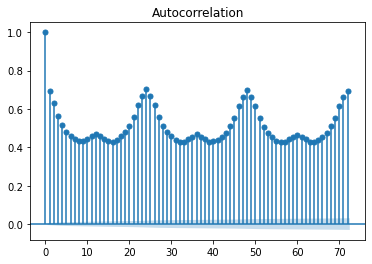

In [103]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(var, lags=72)
plt.show()

In [104]:
def autocov(X, tau):
    autoCov = 0
    for i in np.arange(0, len(X) - tau):
        autoCov += ((X[i+tau]) - np.mean(X)) * (X[i] - np.mean(X))
    
    return (1 / (len(X) - 1)) * autoCov # unbiased

def autocorr(X, tau): # normalize the autocovariance coefficient
    return autocov(X, tau) / autocov(X, 0)